<a href="https://colab.research.google.com/github/sjoon0305/Simulation/blob/main/12. CB_DON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/sjoon0305/Simulation/raw/main/train_data_100.npz
!wget https://github.com/sjoon0305/Simulation/raw/main/vali_data_30.npz

In [9]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
from torch.utils.data import Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def convert_np_to_tensor(array):
    if isinstance(array, np.ndarray):
        return torch.from_numpy(array).to(torch.float32)
    return array

def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("train_data_100.npz")
branch_inputs = branch.to(device)
trunk_input = trunk[0].to(device)
deeponet_outputs = output.to(device)

print("Branch_inputs shape   :", branch_inputs.shape, branch_inputs.device)    # (677, 1, 81, 81)
print("Trunk_input shape    :", trunk_input.shape, trunk_input.device)     # (677, 121, 2)
print("Deeponet_outputs shape:", deeponet_outputs.shape, deeponet_outputs.device)     # (677, 121, 2)

Branch_inputs shape   : torch.Size([100, 41]) cuda:0
Trunk_input shape    : torch.Size([41, 2]) cuda:0
Deeponet_outputs shape: torch.Size([100, 41, 2]) cuda:0


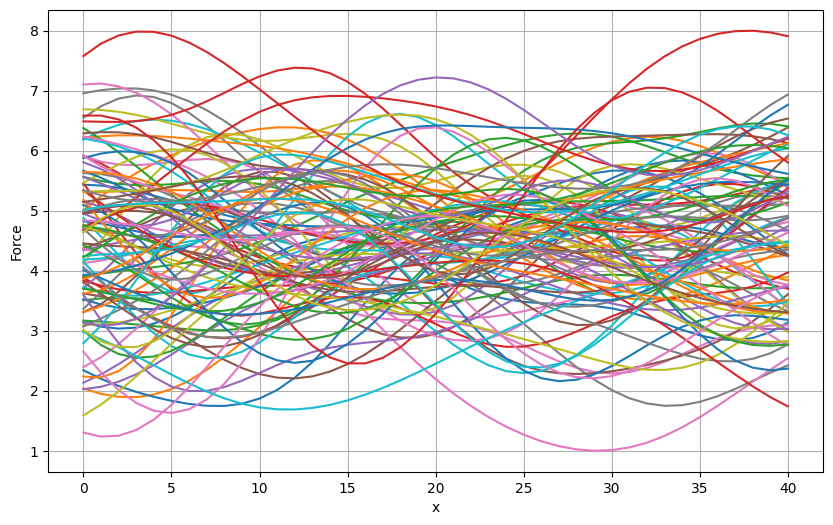

In [10]:
plt.figure(figsize=(10, 6))
for i in range(branch_inputs.shape[0]):
    plt.plot(branch_inputs[i].cpu().detach().numpy().squeeze(), label=f'Branch Input {i}')

# 라벨 및 범례
plt.xlabel("x")
plt.ylabel("Force")
plt.grid(True)
plt.show()

In [13]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    
    self.branch = nn.Sequential(
      nn.Linear(41, 40), nn.ReLU(),  # 30: sensor 차원
      nn.Linear(40, 40), nn.ReLU(),
      nn.Linear(40, 80), nn.ReLU()   # 80: branch net의 차원 
    )
    self.trunk = nn.Sequential(
      nn.Linear(2, 40), nn.ReLU(),   # 3: 노드 차원
      nn.Linear(40, 40), nn.ReLU(),
      nn.Linear(40, 80), nn.ReLU()   # 80: trunk net의 차원 (branch net의 차원과 같아야 함)
    )

    self.output_net = nn.Sequential(
        nn.Linear(80, 100), nn.ReLU(),
        nn.Linear(100, 100), nn.ReLU(),
        nn.Linear(100, 2)   # 최종 출력 (batch_size, 2)
    )
    
  def forward(self, u, y):
    branch_out = self.branch(u)
    trunk_out  = self.trunk(y)
    out = branch_out[:, None, :] * trunk_out
    out = self.output_net(out)
    return out

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    nn.init.zeros_(m.bias)

model = Network()
model = model.to(device)
model.apply(init_weights)

# 손실 함수 및 옵티마이저
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [14]:
n_epochs = 50000
for epoch in range(n_epochs):
            
    optimizer.zero_grad()

    #forward pass through model#
    pred = model(branch_inputs, trunk_input)
    
    loss = loss_fn(pred, deeponet_outputs)

    # Backward pass
    loss.backward()
    optimizer.step()

    
    if epoch % 1000 ==0:
        print(f'Epoch: {epoch}, Loss: {float(loss):.3}')

print(f'Epoch: {epoch+1}, Final Loss: {float(loss):.3}')


Epoch: 0, Loss: 18.3
Epoch: 1000, Loss: 0.00272
Epoch: 2000, Loss: 0.0052
Epoch: 3000, Loss: 0.00691
Epoch: 4000, Loss: 0.00129
Epoch: 5000, Loss: 0.000512
Epoch: 6000, Loss: 0.000346
Epoch: 7000, Loss: 0.000466
Epoch: 8000, Loss: 0.00303
Epoch: 9000, Loss: 0.000119
Epoch: 10000, Loss: 0.000399
Epoch: 11000, Loss: 0.000367
Epoch: 12000, Loss: 0.000986
Epoch: 13000, Loss: 0.00149
Epoch: 14000, Loss: 0.000595
Epoch: 15000, Loss: 0.00061
Epoch: 16000, Loss: 0.000112
Epoch: 17000, Loss: 0.000305
Epoch: 18000, Loss: 0.000606
Epoch: 19000, Loss: 0.000254
Epoch: 20000, Loss: 0.000741
Epoch: 21000, Loss: 3.68e-05
Epoch: 22000, Loss: 1.47e-05
Epoch: 23000, Loss: 1.97e-05
Epoch: 24000, Loss: 0.00156
Epoch: 25000, Loss: 1.35e-05
Epoch: 26000, Loss: 1.05e-05
Epoch: 27000, Loss: 0.000232
Epoch: 28000, Loss: 1.58e-05
Epoch: 29000, Loss: 0.00157
Epoch: 30000, Loss: 1.44e-05
Epoch: 31000, Loss: 1.41e-05
Epoch: 32000, Loss: 9.86e-06
Epoch: 33000, Loss: 1.3e-05
Epoch: 34000, Loss: 5.17e-05
Epoch: 35000,

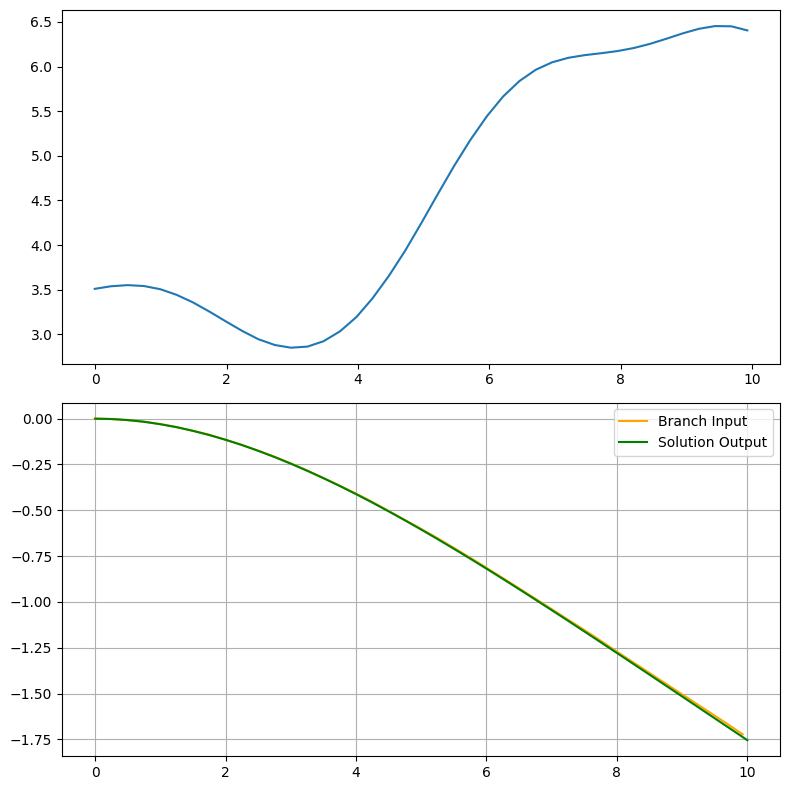

In [22]:
index_test = 22
output_pred_np = model(branch_inputs, trunk_input)[index_test].cpu().detach().numpy()
branch_plot = branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = deeponet_outputs[index_test].detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
axes[0].plot(output_pred_np[:, 0], branch_plot, label='Branch Input')


axes[1].plot(output_pred_np[:, 0], output_pred_np[:, 1] ,color = 'orange', label='Branch Input')
axes[1].plot(solution_plot[:, 0], solution_plot[:, 1] ,color = 'green', label='Solution Output')
axes[1].legend()
axes[1].grid(True)
# 그래프 표시
plt.tight_layout()
plt.show()

In [23]:
def load_training_tensors(file_path):
    data = np.load(file_path)
    branch = convert_np_to_tensor(data['force_func'])
    trunk = convert_np_to_tensor(data['existing_corr'])
    output = convert_np_to_tensor(data['boundary_corr'])
    return branch, trunk, output

branch, trunk, output = load_training_tensors("vali_data_30.npz")
vali_branch_inputs = branch.to(device)
vali_trunk_input = trunk[0].to(device)
vali_deeponet_outputs = output.to(device)

print("vali branch_inputs shape   :", vali_branch_inputs.shape, vali_branch_inputs.device)    # (677, 1, 81, 81)
print("vali trunk_input shape    :", vali_trunk_input.shape, vali_trunk_input.device)     # (677, 121, 2)
print("vali deeponet_outputs shape:", vali_deeponet_outputs.shape, vali_deeponet_outputs.device)     # (677, 121, 2)

vali branch_inputs shape   : torch.Size([30, 41]) cuda:0
vali trunk_input shape    : torch.Size([41, 2]) cuda:0
vali deeponet_outputs shape: torch.Size([30, 41, 2]) cuda:0


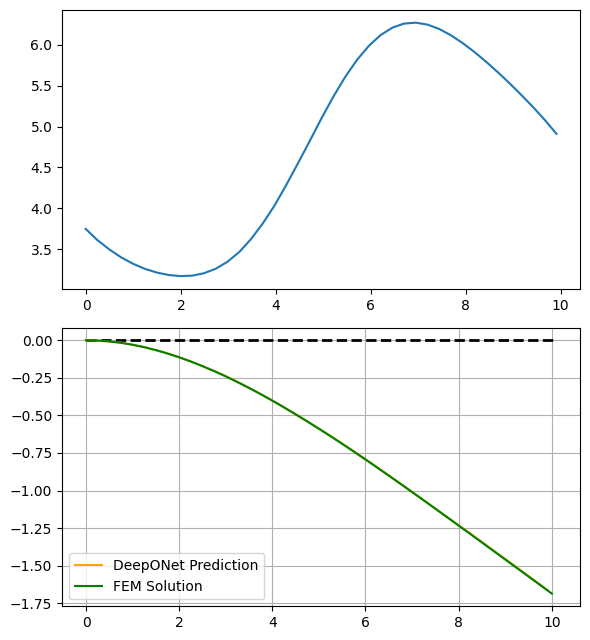

In [24]:
index_test = 13
output_pred_np = model(vali_branch_inputs, vali_trunk_input)[index_test].cpu().detach().numpy()
branch_plot = vali_branch_inputs[index_test].detach().cpu().numpy().squeeze()
solution_plot = vali_deeponet_outputs[index_test].detach().cpu().numpy().squeeze()

fig, axes = plt.subplots(2, 1, figsize=(6, 6.5))
axes[0].plot(output_pred_np[:, 0], branch_plot, label='Force Input')


axes[1].hlines(0, xmin=0, xmax=10.1, colors='black', linestyles='--', linewidth=2)
axes[1].plot(output_pred_np[:, 0], output_pred_np[:, 1],color = 'orange', label='DeepONet Prediction')
axes[1].plot(solution_plot[:, 0], solution_plot[:, 1],color = 'green', label='FEM Solution')
axes[1].grid(True)
axes[1].legend(loc='lower left')
# 그래프 표시
plt.tight_layout()
plt.show()